In [155]:
import os, json
import rasterio
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

In [258]:
LABELS_DIR ='nwpu_labels'
IMAGES_DIR = 'nwpu_images'
# MASKS_DIR = 'nwpu_masks'
IMAGES_TRAIN_DIR = 'nwpu_images/train/data'
IMAGES_VALID_DIR='nwpu_images/valid/data'
MASKS_TRAIN_DIR = 'nwpu_masks/train/data'
MASKS_VALID_DIR = 'nwpu_masks/valid/data'

In [162]:
def load_json_files():
    files = os.listdir(LABELS_DIR)
    directory = LABELS_DIR
    data = [json.load(open(os.path.join(directory, file))) for file in files]
    data_merged =  {}
    for datum in data:
        data_merged.update(datum)
    return data_merged

def load_images(files):
    images = {}
    for file in files:
        with rasterio.open(file,'r') as dataset:
            key = os.path.basename(file)
            images[key]=dataset.read().T
    return images

def generate_polygon(data, info):
    # get the dimensions of the image
    nx, ny, nz = data.shape
    mask = np.zeros((ny,nx))
    for key in info['regions'].keys():
        x = info['regions'][key]['shape_attributes']['all_points_x']
        y = info['regions'][key]['shape_attributes']['all_points_y']
  
        # the ImageDraw.Draw().polygon function we will use to create the mask
        # requires the x's and y's are interweaved, which is what the following
        # one-liner does    
        polygon = np.vstack((x,y)).reshape((-1,),order='F').tolist()

        # create a mask image of the right size and infill according to the polygon
        if nx>ny:
            x,y = y,x 
            img = Image.new('L', (ny, nx), 0)
        #elif ny>nx:
        #    x,y = y,x 
        #    img = Image.new('L', (ny, nx), 0)            
        else:
            img = Image.new('L', (nx, ny), 0)

        ImageDraw.Draw(img).polygon(polygon, outline=1, fill=1)
        # turn into a numpy array
        m = np.array(img)
        mask = mask + m
    return mask



In [163]:
#load json files and merge
file_info=load_json_files()

In [164]:
#load sample image
images=load_images(['nwpu_images/data/lake_648.jpg'])

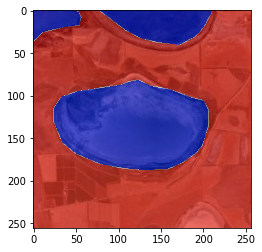

In [320]:
#plot testing mask generation
plt.imshow(images['lake_648.jpg'])
mask = generate_polygon(images['lake_648.jpg'],file_info['lake_648.jpg'])
plt.imshow(mask.T, cmap='bwr_r', alpha=0.5)

In [168]:
#create destination directory for the various masks
os.makedirs(MASKS_TRAIN_DIR, exist_ok=True)
matplotlib.image.imsave(os.path.join(mask_dir,'lake_648.jpg'), mask.T.astype('uint8'))

In [336]:
#generate masks for all of the files
images = load_images([os.path.join(IMAGES_DIR,'test','data',f) for f in file_info.keys()])
length = len(file_info.keys())
counter = 0
image_destination_file = ''
mask_destination_file = ''
data = []
for key in file_info.keys():
    mask = generate_polygon(images[key],file_info[key])
    if counter < int(0.7*length):
        image_destination_file = os.path.join(IMAGES_TRAIN_DIR,key)
        mask_destination_file = os.path.join(MASKS_TRAIN_DIR,key)
    else :
        image_destination_file = os.path.join(IMAGES_VALID_DIR,key)
        mask_destination_file = os.path.join(MASKS_VALID_DIR,key)
        
    os.popen('cp {0} {1}'.format(os.path.join(IMAGES_DIR,'test','data',key),image_destination_file)) 
    matplotlib.image.imsave(mask_destination_file, mask.T.astype('uint8'))
    counter +=1
    data.append((images[key],mask.T.reshape((256,256,1))))